# Cox proportional hazard model

Voor mijn verdiepende model ga ik mijn verdiepen in het "Cox Proportional hazard model". Dit is een niet lineair regressie model. Het plan voor dit onderzoek is het toepassen van een al gemaakte library, op een door kaggle vekregen dataset die later tevoorschijn komt. Om het model en de achterliggende werking te begrijpen zal ik ook een poging doen om het model na te maken, en deze dan vergelijken met de eerder benoemde library.

## Achtergrond informatie

Dit model valt onder een gebied is statistiek genaamd "Survival analysis". Deze hoek van statistiek houd zich bezich met het analyseren van resultaten die te maken hebben met een tijds-component (Deo et al., 2020). Bij outcome research wordt er vaak een hazard ratio bepaald doormiddel van het hazard model, deze wordt gebruikt om te bepalen of het onderzoek het gewilde effect gehad heeft.

Het Cox propertional hazard model (CPHM) is in 1972 bedacht door David Cox. Dit model kan gebruikt worden om het effect van meerdere continue en categorische variabelen op de survival te bepalen. Het kwantificeren van verschillen in survival verdelingen tussen groepen wordt gedaan door het berekenen van een hazard ratio. Deze ratio is de ratio van de trend van een gebeurtenis op elk mogelijk moment van 1 groep in verhouding tot de andere groep (Deo et al., 2021).

CPMH gebruikt de verschillende covariates (variabelen die mogelijk impact kunnen hebben op een event) samen met een bijbehorende coefficient (beta). Deze beta waarden representeren de log-hazard ratio van de bijbehorende covariate. Een positieve beta-value houd in dat de kans op het event (zoals bijvoorbeeld sterven) verhoogt. Een negatieve beta-value is dan ook geassocieerd met een lagere kans op het event. rond de 0 is geen verschil in kans. Als je een covariate age hebt met een beta-value van 0.2, houd in dat als age met 1 toeneemt er een 20% increase van de log-hazard van het event. Dit is in log scale, en kan lastig zijn om te interpreteren. Dit kan verbeterd worden door de beta value als een exponent voor e te nemen. Dit geeft de hazard ratio (HR). Een HR > 1 houd weer een increase van risk in. < 1 een decrease en rond de 1 blijft de risk gelijk.

## Data
Ik gebruik data van de R package genaamd "survival". De dataset gaat over longkanker en heb ik weggeschreven naar een csv bestand. Mijn plan is om langzaam de verschillende stappen van CPHM uit te werken op deze data. Met uitleg erbij over de stappen die gezet worden. Aller eerst moet er gekeken worden naar de data zelf. En mogelijk wat dingen veranderd worden. Deze dataverwerking ga ik uitvoeren met polars, deze library lijkt wat meer op R en is mijn voorkeur boven pandas.


In [15]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
df = pl.read_csv("lungcancer_survival.csv", has_header=True, null_values="NA")
df

inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
3,306,2,74,1,1,90,100,1175,null
3,455,2,68,1,0,90,90,1225,15
3,1010,1,56,1,0,90,90,null,15
5,210,2,57,1,1,90,60,1150,11
1,883,2,60,1,0,100,90,null,0
…,…,…,…,…,…,…,…,…,…
1,188,1,77,1,1,80,60,null,3
13,191,1,39,1,0,90,90,2350,-5
32,105,1,75,2,2,60,70,1025,5


De data is nu ingelezen. We zien een aantal vanzelfsprekende kolommen. Status is overleden of niet (1 en 2). Sex man:1 vrouw:2. Ik wil deze encodings graag omzetten naar 0 en 1 voor leesbaarheid.

De data bestaat uit 228 rijen, en 10 kolommen

In [17]:
df = df.with_columns(
    pl.col("status").replace([1,2], [0,1]),
    pl.col("sex").replace([1,2], [0,1])
)

df.head()

inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
3,306,1,74,0,1,90,100,1175,null
3,455,1,68,0,0,90,90,1225,15
3,1010,0,56,0,0,90,90,null,15
5,210,1,57,0,1,90,60,1150,11
1,883,1,60,0,0,100,90,null,0


Ook is er zichtbaar dat er verschillende NA waarden zijn. Ik wil graag bepalen hoeveel dit er zijn zodat ik kan bepalen of ik deze wil verwijderen, of imputeren.

In [18]:
sum(df.describe().row(1)[1:])

67.0

Hieruit blijkt het dat er 67 rijen zijn met een NA waarde. Omdat ik aardig krap zit met tijd voor deze opdracht besluit ik om deze eerst te verwijderen. Als er tijd oveblijft zal ik gaan kijken naar data imputatie.

In [19]:
df_nulless = df.drop_nulls()
df_nulless

inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
3,455,1,68,0,0,90,90,1225,15
5,210,1,57,0,1,90,60,1150,11
12,1022,0,74,0,1,50,80,513,0
7,310,1,68,1,2,70,60,384,10
11,361,1,71,1,2,60,80,538,1
…,…,…,…,…,…,…,…,…,…
11,203,0,71,1,1,80,90,1025,0
13,191,0,39,0,0,90,90,2350,-5
32,105,0,75,1,2,60,70,1025,5


Nu de data inprincipe schoon gemaakt is, kan ik weer verdiepen op survival analyses en het CPHM. Om eerst wat meer begrip te krijgen van survival analyses wil ik gaan kijken naar de Kaplan Meier curve. Deze curve geeft weer wat de survival probability is over tijd. Ik wil deze beter begrijpen door zelf een implementatie te maken in polars. Deze zal ik vervolgens vergelijken met een al gemaakte class uit de lifelines library.

In [20]:
from lifelines import KaplanMeierFitter

Ik ga eerst een simpel test setje maken, deze zal gebruikt worden om mijn en lifelines implementatie te vergelijken met elkaar.

<Axes: xlabel='timeline'>

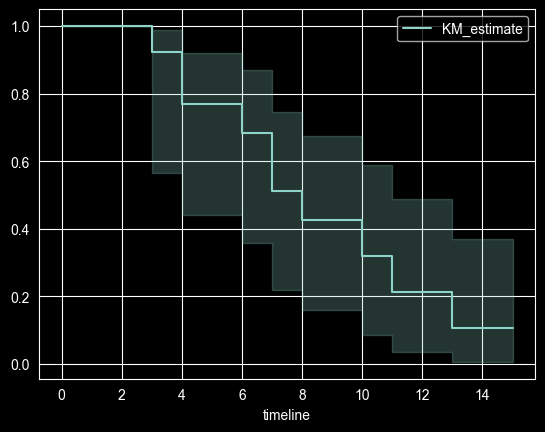

In [21]:
T = [3,4,4,4,6,7,7,8,9,10,11,13,15]
E = [1,1,1,0,1,1,1,1,0,1,1,1,0]

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed = E)
kmf.plot_survival_function()

De verkregen plot van lifelines geeft de survival probability weer over de timeline die voorkomt in de data. Deze geeft weer dat hoe lang de tijd doorloopt, hoe meer de survival probability zal dalen. Ik ben van plan om de implementatie te baseren op wat ik vind op het internet. De bronnen hiervoor zullen vermeld worden. https://www.youtube.com/watch?v=L_ziqYhksG8.

### KaplanMeier implementatie
Lifelines implementatie gebruikt 2 arrays als input, eentje die de tijdlijn bevat en eentje die de censorings bevat. Dit wil ik ook gaan doen, maar dan als polars dataframe.

In [22]:
kaplan_input_df = pl.DataFrame({
    "time": T,
    "e": E
})
kaplan_input_df

time,e
i64,i64
3,1
4,1
4,1
4,0
6,1
…,…
9,0
10,1
11,1


Met deze dataframe kan ik de M, N en Q gaan berekenen. Ik zal hieronder uitleggen wat deze waarden inhouden.

- M: hoeveel events per tijd een waarde hebben van 1
- N: hoeveelheid subjects die op dat tijds-punt voor het event nog meedoen
- Q: hoeveelheid events per tijds-punt met een waarde van 0, als deze een M > 0 hebben. Anders zal deze het vorige tijds-punt opgeteld worden.

De verschillende stappen worden in het volgende code block toegepast.

In [23]:
result = (
    kaplan_input_df
    # Bereken de m (censor = 1) en q (censor = 0) aantallen voor elk tijds-punt
    .group_by("time")
    .agg(
        m = pl.col("e").sum().cast(pl.Int64),
        q = pl.col("e").eq(0).sum().cast(pl.Int64)
    ).sort("time")

    # Geef de censor van i+1 aan de q van i als m[i+]
    .with_columns(
        next_q = pl.when(pl.col("m").shift(1) > 0)
        .then(pl.col("q").shift(-1))
        .otherwise(0)
    )
    .with_columns(
        q = pl.when(pl.col("next_q").is_null() | pl.col("next_q") == 0)
        .then(pl.col("q"))
        .otherwise(pl.col("next_q"))
    )
    # Haal alle tijden met m < 0 weg.
    .filter(pl.col("m") > 0).drop("next_q")
    .vstack(pl.DataFrame({"time":[0], "m": [0], "q": [0]}))
    .sort("time")

    # Bereken de afname van subjects overtijd.
    .with_columns(
        total_subjects=pl.lit(len(kaplan_input_df)),
        cumulative_m=pl.col("m").cum_sum(),
        cumulative_q=pl.col("q").cum_sum()
    )
    .with_columns(
        n=pl.col("total_subjects") - pl.col("cumulative_m").shift(1) - pl.col("cumulative_q").shift(1)
    )
    .with_columns(
        n=pl.when(pl.col("time") == 0).then(pl.col("total_subjects")).otherwise(pl.col("n"))
    ).select(["time", "m", "q", "n"])
)

result

time,m,q,n
i64,i64,i64,i64
0,0,0,13
3,1,0,13
4,2,1,12
6,1,0,9
7,2,0,8
…,…,…,…
9,0,1,4
10,1,0,3
11,1,0,2


Hier wordt de survival probability berekend.

In [24]:
result = (
    result
    .with_columns(
        prob_survive = (pl.col("n") - pl.col("m")) / pl.col("n")
    ).with_columns(
    # Cumulative product starting from 1.0
    s = pl.col("prob_survive").cum_prod()
    ).drop("prob_survive")
)

result

time,m,q,n,s
i64,i64,i64,i64,f64
0,0,0,13,1.0
3,1,0,13,0.923077
4,2,1,12,0.769231
6,1,0,9,0.683761
7,2,0,8,0.512821
…,…,…,…,…
9,0,1,4,0.42735
10,1,0,3,0.2849
11,1,0,2,0.14245


Met deze verkregen data kan je een step-plot maken. En deze kan vervolgens vergeleken worden met de lifelines implementatie.

In [25]:
sns.lineplot(result, x = "time", y = "s", drawstyle='steps-post')

RuntimeError: Encountered an exception when converting data source to a pandas DataFrame. See traceback above for details.

Deze grafiek komt goed overeen met de verkregen grafiek uit de lifelines library. Nu kan ik deze techniek gaan toepassen op de verkrgen lung cancer data. Hiervoor kan direct de df-nulless gebruikt worden. Alleen zullen de namen van de kolommen anders moeten heten.

In [ ]:
from classes.KaplanMeier import KaplanMeier
kaplanmeier = KaplanMeier()
null_less_kaplan_result = kaplanmeier.fit(df_nulless.select(["time", "status"]).rename({"status": "censored"}))

sns.lineplot(null_less_kaplan_result, x = "time", y = "s", drawstyle = "steps-post")
plt.xlabel("Time in days")
plt.ylabel("Survival probability")
plt.title("Kaplan meier curve")
plt.show()

Wat deze grafiek zichtbaar maakt is dat de survival probability heel erg snel daalt. Na 300 dagen zit deze al rond 50%. Vanaf 800 dagen zit deze op het laagste punt net onder 20%. Hetzelfde is zichtbaar in de grafiek hieronder van lifelines. Deze laat de lijn doorlopen tot het hoogste tijd punt in de data. Wat mijn implementatie momenteel niet doet. Voor de rest lijken de 2

In [ ]:
time = df_nulless["time"].to_list()
censored = df_nulless["status"].to_list()

KaplanMeierFitter().fit(time, event_observed = censored).plot_survival_function()

Deze data kan gebruikt worden om de hazard te berekenen, ofwel de kans dat een patient dood gaat tussen 2 tijd punten. (TileStats, 2023). Dit ga ik nu berekenen voor een hazard rate step plot.

<Axes: xlabel='time', ylabel='h'>

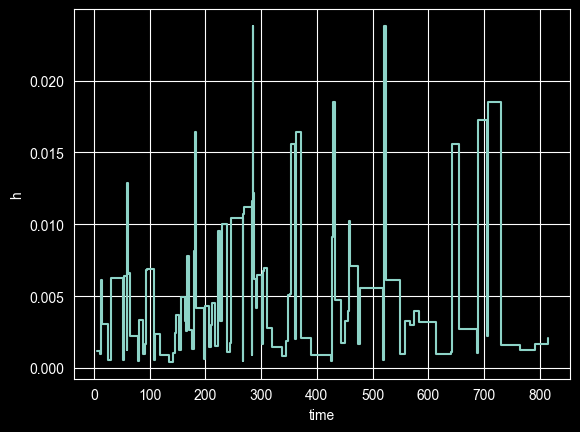

In [33]:
hazard_rate_data = (
    null_less_kaplan_result
    .with_columns(
        delta_time = pl.col("time")-pl.col("time").shift(1)
    ).filter(pl.col("delta_time").is_not_null())
    .with_columns(
        h = (pl.col("m") / pl.col("n") / pl.col("delta_time"))
    ).drop("delta_time")
)

sns.lineplot(hazard_rate_data, x = "time", y = "h", drawstyle = "steps-post")

<Axes: xlabel='time', ylabel='cum_hazard'>

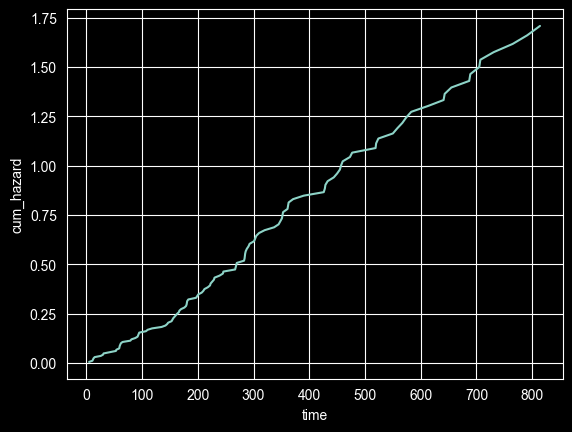

In [49]:
cum_hazard_rate = (
    hazard_rate_data
    .with_columns(
        delta_time = pl.col("time")-pl.col("time").shift(1).fill_null(0)
    )
    .with_columns(
        interval_contrib = pl.col("h") * pl.col("delta_time"),
    )
    .with_columns(
        cum_hazard = pl.col("interval_contrib").cum_sum()
    ).drop(["interval_contrib", "delta_time"])

)

sns.lineplot(cum_hazard_rate, x = "time", y = "cum_hazard")

In [31]:
hazard_rate_data

time,m,q,n,s,h
i64,i64,i64,i64,f64,f64
5,1,0,167,0.994012,0.001198
11,1,0,166,0.988024,0.001004
12,1,0,165,0.982036,0.006061
13,1,0,164,0.976048,0.006098
15,1,0,163,0.97006,0.003067
…,…,…,…,…,…
707,1,0,27,0.211926,0.018519
731,1,1,26,0.203775,0.001603
765,1,0,24,0.195284,0.001225
